In [351]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
%matplotlib inline
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import chart_studio.plotly as py
import numpy as np
import datetime as datetime
from datetime import date, timedelta
import requests
import io
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from IPython.display import Markdown as md
import math
# Function for displaying the map
def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='700px')

We define a function to get the raw data from the corresponding url and retruning it as a dataframe.
<br>This function allows us to get the latest updates.

In [352]:
def get_raw_data(url):
    req = requests.get(url).content
    return pd.read_csv(io.StringIO(req.decode('utf-8')))

# Worldwide Analysis

Import the latest reports from CSSE at Johns Hopkins University.
<br> Date of the latest data to be gathered is "yesterday" to ensure the data is available as the files are updated daily at midnight.
<br> We use the date variable "yesterday" to build the urls dynamically.

In [353]:
yesterday = date.today() - timedelta(days=1)
yesterday = yesterday.strftime("%m-%d-%Y") 

In [354]:
world_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{}.csv".format(yesterday)
confirmed_w_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
fatalities_w_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"
recovered_w_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv"
da_world = get_raw_data(world_url)
da_confirmed_w = get_raw_data(confirmed_w_url)
da_fatalities_w = get_raw_data(fatalities_w_url)
da_recovered_w = get_raw_data(recovered_w_url)

First look at the overall data. 

In [355]:
da_world.head(5)

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Hubei,China,2020-03-21T10:13:08,67800,3139,58946,30.9756,112.2707
1,NaN,Italy,2020-03-21T17:43:03,53578,4825,6072,41.8719,12.5674
2,NaN,Spain,2020-03-21T13:13:30,25374,1375,2125,40.4637,-3.7492
3,NaN,Germany,2020-03-21T20:43:02,22213,84,233,51.1657,10.4515
4,NaN,Iran,2020-03-21T11:13:12,20610,1556,7635,32.4279,53.6880


We clean up the data and consolidate the names of countries with several variations or the article after the name.

We rename the entries for South Korea.

In [356]:
da_world["Country/Region"] = da_world["Country/Region"].replace("Korea, South","South Korea")
da_confirmed_w["Country/Region"] = da_confirmed_w["Country/Region"].replace("Korea, South","South Korea")
da_fatalities_w["Country/Region"] = da_fatalities_w["Country/Region"].replace("Korea, South","South Korea")
da_recovered_w["Country/Region"] = da_recovered_w["Country/Region"].replace("Korea, South","South Korea")

Consolidate the name of Republic of Congo for all possible variants.

In [444]:
list_congo = da_world[da_world["Country/Region"].str.contains("Congo")].index
for x in list_congo:
    da_world.loc[x,"Country/Region"] = "Republic of the Congo"
    da_confirmed_w.loc[x,"Country/Region"] = "Republic of the Congo"
    da_fatalities_w.loc[x,"Country/Region"] = "Republic of the Congo"
    da_recovered_w.loc[x,"Country/Region"] = "Republic of the Congo"
da_world[da_world["Country/Region"].str.contains("Congo")]

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude,Active
191,NaN,Republic of the Congo,2020-03-21T12:43:08,23,1,0,-4.0383,21.7587,22
246,NaN,Republic of the Congo,2020-03-19T20:13:56,3,0,0,-0.2280,15.8277,3
301,NaN,Republic of the Congo,2020-03-17T21:33:03,0,0,0,-1.4400,15.5560,0


In [445]:
list_gambia = da_world[da_world["Country/Region"].str.contains("Gambia")].index
for x in list_gambia:
    da_world.loc[x,"Country/Region"] = "The Gambia"
    da_confirmed_w.loc[x,"Country/Region"] = "The Gambia"
    da_fatalities_w.loc[x,"Country/Region"] = "The Gambia"
    da_recovered_w.loc[x,"Country/Region"] = "The Gambia"
da_world[da_world["Country/Region"].str.contains("Gambia")]

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude,Active
279,NaN,The Gambia,2020-03-18T14:13:56,1,0,0,13.4432,-15.3101,1
303,NaN,The Gambia,2020-03-18T14:13:56,0,0,0,13.4667,-16.6000,0


We add a column for the active positive cases. 
<br>Our main interest is to see how the numbers of active cases are changing. 

In [446]:
da_world["Active"] = da_world["Confirmed"] - da_world["Recovered"] - da_world["Deaths"]

## Global numbers in a nutshell

In [447]:
total_w = da_world[["Confirmed","Active","Recovered","Deaths"]].sum()
total_w

Confirmed    304528
Active       199879
Recovered     91676
Deaths        12973
dtype: int64

We group the dataset by countries to have a total value per nation and list the top five countries with active cases.

In [448]:
total_countries = da_world.groupby("Country/Region")[["Confirmed","Active","Recovered","Deaths"]].sum(
              ).sort_values(by="Active",ascending=False)
total_countries.head()

,Confirmed,Active,Recovered,Deaths
Country/Region,,,,
Italy,53578,42681,6072,4825
US,25493,25015,171,307
Germany,22213,21896,233,84
Spain,25374,21874,2125,1375
France,14308,13734,12,562


We add the geographical coordinates for each country to build a worlwide map.

In [449]:
total_countries["lat"]= np.nan
total_countries["long"]= np.nan
total_countries.head()

,Confirmed,Active,Recovered,Deaths,lat,long
Country/Region,,,,,,
Italy,53578,42681,6072,4825,NaN,NaN
US,25493,25015,171,307,NaN,NaN
Germany,22213,21896,233,84,NaN,NaN
Spain,25374,21874,2125,1375,NaN,NaN
France,14308,13734,12,562,NaN,NaN


In [450]:
total_countries["lat"]= np.nan
total_countries["long"]= np.nan
total_countries = total_countries.reset_index()
len(total_countries)

175

In [451]:
countries = total_countries["Country/Region"]
countries

0            Italy
1               US
2          Germany
3            Spain
4           France
          ...     
170           Guam
171       Guernsey
172         Jersey
173          Nepal
174    Puerto Rico
Name: Country/Region, Length: 175, dtype: object

We gather the longitude and latitude per country from the da_world dataset.
<br>As there are several regions for some countries, we drop duplicate values of countries and keep the first one as reference for the geographical coordinates.The final length of the resulting dataframe single_countries shall match the length of total_countries.

In [452]:
single_countries = da_world.drop_duplicates(subset="Country/Region", keep="first")
single_countries = single_countries[["Country/Region","Latitude","Longitude"]]
len(single_countries)

175

In [453]:
total_countries.head()

,Country/Region,Confirmed,Active,Recovered,Deaths,lat,long
0,Italy,53578,42681,6072,4825,NaN,NaN
1,US,25493,25015,171,307,NaN,NaN
2,Germany,22213,21896,233,84,NaN,NaN
3,Spain,25374,21874,2125,1375,NaN,NaN
4,France,14308,13734,12,562,NaN,NaN


In [454]:
single_countries.head()

,Country/Region,Latitude,Longitude
0,China,30.9756,112.2707
1,Italy,41.8719,12.5674
2,Spain,40.4637,-3.7492
3,Germany,51.1657,10.4515
4,Iran,32.4279,53.6880


In [455]:
for x in range(len(countries)-1):
    #print(single_countries[single_countries["Country/Region"].str.contains(
    #                            countries[x]) == True][["Latitude","Longitude"]].to_numpy())
    location_shape = (single_countries[single_countries["Country/Region"].str.contains(
                                 countries[x]) == True][["Latitude","Longitude"]].to_numpy()).shape
    #print(countries[x],location_shape)
    if location_shape != (1,2):
        print(countries[x])
        total_countries.loc[x,["lat","long"]] = np.nan
    else:
        total_countries.loc[x,["lat"]]= single_countries[single_countries["Country/Region"].str.contains(
                                 countries[x]) == True]["Latitude"].to_numpy()
        total_countries.loc[x,["long"]]=single_countries[single_countries["Country/Region"].str.contains(
                                 countries[x]) == True]["Longitude"].to_numpy()

Guinea
Niger


In [456]:
total_countries.loc["Gambia","lat"] = 9.9456
total_countries.loc["Gambia","long"] = 9.6966
total_countries.loc["Niger","lat"] = 17.6078
total_countries.loc["Niger","long"] = 8.0817
total_countries.loc["Puerto Rico","lat"] = 18.2208
total_countries.loc["Puerto Rico","long"] = 66.5901

In [534]:
total_countries.head()

,Country/Region,Confirmed,Active,Recovered,Deaths,lat,long
0,Italy,53578.0,42681.0,6072.0,4825.0,41.8719,12.5674
1,US,25493.0,25015.0,171.0,307.0,42.1657,-74.9481
2,Germany,22213.0,21896.0,233.0,84.0,51.1657,10.4515
3,Spain,25374.0,21874.0,2125.0,1375.0,40.4637,-3.7492
4,France,14308.0,13734.0,12.0,562.0,46.2276,2.2137


In [535]:
total_countries[["lat","long"]].isnull().values.any()

True

We create a map where each country with active casesis labeled as follows:
Blue circle: less than 1000 reported active cases.
Orange circle: more than 1000 and less than 10000 reported active cases.
Red circle: more than 10000 reported active cases.

In [536]:
np.isnan(total_countries.loc[0]['lat'])

False

In [537]:
world_map = folium.Map(location=[41.8719, 12.5674], tiles='cartodbpositron', zoom_start=2.5)
def color_producer(val):
    if val < 1000:
        return 'blue'
    elif val < 10000:
        return 'orange'
    else:
        return 'red'

for i in range(0,len(total_countries)):
    if not(np.isnan(total_countries.iloc[i]['lat']) or np.isnan(
            total_countries.iloc[i]['long'])):
        folium.Circle(       
        location=[total_countries.iloc[i]['lat'], total_countries.iloc[i]['long']],
        popup=("Confirmed cases: " + str(total_countries.iloc[i]["Confirmed"])+"<br>"
               "Active cases: " + str(total_countries.iloc[i]["Active"])+"<br>"
               "Recovered: " + str(total_countries.iloc[i]["Recovered"])+"<br>"
               "Deaths: " + str(total_countries.iloc[i]["Deaths"])),
        radius=(total_countries.iloc[i]['Active']*2000000)/total_countries['Active'].sum(), 
        color=color_producer(total_countries.iloc[i]['Active']),
        fill_color=color_producer(total_countries.iloc[i]['Active']),
        title='Covid-19 active cases worldwide').add_to(world_map)     
embed_map(world_map, 'world_map.html')

Summary data per country is shown if you click on each country's circle.

## Top 15 countries by number of active cases

We list the fifteen countries with most active cases.
<br>As of 18.03.20, China is on the 5th place. 
<br>Although it has the biggest number of confirmed cases the rate of recovered case is high and the the new cases are going down drastically. 
<br> We also calculate the death rate vs confirmed positive cases and include it in the column "Death rate".

In [461]:
top_fifteen = total_countries.head(15)
top_fifteen["Death rate [%]"] = round(100*top_fifteen["Deaths"]/ top_fifteen["Confirmed"],2)
top_fifteen

/git/github.com/kwulffert/covid-19-analysis/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Country/Region,Confirmed,Active,Recovered,Deaths,lat,long,Death rate [%]
0,Italy,53578.0,42681.0,6072.0,4825.0,41.8719,12.5674,9.01
1,US,25493.0,25015.0,171.0,307.0,42.1657,-74.9481,1.20
2,Germany,22213.0,21896.0,233.0,84.0,51.1657,10.4515,0.38
3,Spain,25374.0,21874.0,2125.0,1375.0,40.4637,-3.7492,5.42
4,France,14308.0,13734.0,12.0,562.0,46.2276,2.2137,3.93
5,Iran,20610.0,11419.0,7635.0,1556.0,32.4279,53.6880,7.55
6,South Korea,8799.0,7157.0,1540.0,102.0,35.9078,127.7669,1.16
7,Switzerland,6575.0,6485.0,15.0,75.0,46.8182,8.2275,1.14
8,China,81305.0,6189.0,71857.0,3259.0,30.9756,112.2707,4.01
9,United Kingdom,5067.0,4766.0,67.0,234.0,55.3781,-3.4360,4.62


The value of death rate can be interpreted from several perspective. 
<br>Italy has the hightest death rate and tests are done massively. 
<br>Most of the fatalities have been elderly people and people with health preconditions. 
<br>Italy is the second country in the world after Japan with the oldest population.
<br>In contrast UK has a higher death rate than France, South Korea, US and Switzerlad but this value is difficult to compare as in the UK testing has been limited only to people going to hospital and showing symptons. The UK goverment estimates that there might be up to 5k active cases at the moment(status 17.03.2020).

In [532]:
fig = px.treemap(top_fifteen,
                 path=['Country/Region'],
                 values=top_fifteen['Active'],
                 title='Top 15 Countries with Active Cases: status {}'.format(yesterday),
                 hover_data=['Confirmed', 'Active', 'Recovered','Deaths','Death rate [%]'],
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.show()

Summary data per country is shown if you point with the mouse on each country's block.

## Time trends for top four countries by number cases

In [487]:
top_four = top_fifteen["Country/Region"][0:4]
top_four

0      Italy
1         US
2    Germany
3      Spain
Name: Country/Region, dtype: object

We check the shape of the datasets for worldwide confimed, recovered and fatalities and group them by country to avoid several entries per country. 

In [488]:
top_fifteen.head()

,Country/Region,Confirmed,Active,Recovered,Deaths,lat,long,Death rate [%]
0,Italy,53578.0,42681.0,6072.0,4825.0,41.8719,12.5674,9.01
1,US,25493.0,25015.0,171.0,307.0,42.1657,-74.9481,1.20
2,Germany,22213.0,21896.0,233.0,84.0,51.1657,10.4515,0.38
3,Spain,25374.0,21874.0,2125.0,1375.0,40.4637,-3.7492,5.42
4,France,14308.0,13734.0,12.0,562.0,46.2276,2.2137,3.93


In [489]:
print("Shape of worldwide confirmed cases table: {}".format(da_confirmed_w.shape))
print("Shape of worldwide fatalities table: {}".format(da_fatalities_w.shape))
print("Shape of worldwide recovered table: {}".format(da_recovered_w.shape))

Shape of worldwide confirmed cases table: (482, 64)
Shape of worldwide fatalities table: (482, 64)
Shape of worldwide recovered table: (482, 64)


In [490]:
da_conf_grouped = da_confirmed_w.groupby("Country/Region")
da_fat_grouped = da_fatalities_w.groupby("Country/Region")
da_rec_grouped = da_recovered_w.groupby("Country/Region")
print("Length of unique country values for worldwide confirmed cases: {}".format(len(da_conf_grouped)))
print("Length of unique country values for worldwide fatalities: {}".format(len(da_fat_grouped)))
print("Length of unique country values for worldwide recovered: {}".format(len(da_rec_grouped)))

Length of unique country values for worldwide confirmed cases: 167
Length of unique country values for worldwide fatalities: 167
Length of unique country values for worldwide recovered: 167


In [491]:
def top_four_filter(da, top_four, status):
    da_filter = pd.DataFrame([da.get_group(x).drop(
                            ["Province/State", "Lat", "Long"], axis=1).sum() for x in top_four])
    
    for x in range(len(da_filter)):
        if "China" in da_filter.iloc[x,0]:
            da_filter.iloc[x,0]="China"
        if "US" in da_filter.iloc[x,0]:
            da_filter.iloc[x,0]="US"
            
    da_filter["Country/Region"]=da_filter["Country/Region"] + " " +status
    return da_filter

Add China and South Korea to the list for comparison reasons.

In [492]:
comparison_countries = pd.Series(["China","South Korea"])
top_four =top_four.append(comparison_countries, ignore_index=True)
top_four

0          Italy
1             US
2        Germany
3          Spain
4          China
5    South Korea
dtype: object

In [493]:
comparison_countries = pd.Series(["China","South Korea"])
top_four.append(comparison_countries)
top_four_all = top_four_filter(da_conf_grouped, top_four, "confirmed").append(
               top_four_filter(da_fat_grouped, top_four, "fatalities").append(
              top_four_filter(da_rec_grouped, top_four, "recovered")))

In [494]:
top_four_all = top_four_all.T
top_four_all.columns = top_four_all.iloc[0]
top_four_all = top_four_all.drop(top_four_all.index[0])
top_four_all = top_four_all.reset_index()
top_four_all = top_four_all.rename(columns={"index":"Date"})

In [495]:
top_four_all.tail(5)

Country/Region,Date,Italy confirmed,US confirmed,Germany confirmed,Spain confirmed,China confirmed,South Korea confirmed,Italy fatalities,US fatalities,Germany fatalities,Spain fatalities,China fatalities,South Korea fatalities,Italy recovered,US recovered,Germany recovered,Spain recovered,China recovered,South Korea recovered
55,3/17/20,31506,6421,9257,11748,81058,8320,2503,108,24,533,3230,81,2941,17,67,1028,68798,1407
56,3/18/20,35713,7783,12327,13910,81102,8413,2978,118,28,623,3241,84,4025,0,105,1081,69755,1540
57,3/19/20,41035,13677,15320,17963,81156,8565,3405,200,44,830,3249,91,4440,0,113,1107,70535,1540
58,3/20/20,47021,19100,19848,20410,81250,8652,4032,244,67,1043,3253,94,4440,0,180,1588,71266,1540
59,3/21/20,53578,25489,22213,25374,81305,8799,4825,307,84,1375,3259,102,6072,0,233,2125,71857,1540


In [496]:
for x in top_four:
    top_four_all[x + " active"] = top_four_all[x+" confirmed"] - top_four_all[
        x+" recovered"] - top_four_all[x+" fatalities"]
top_four_all.tail()

Country/Region,Date,Italy confirmed,US confirmed,Germany confirmed,Spain confirmed,China confirmed,South Korea confirmed,Italy fatalities,US fatalities,Germany fatalities,...,Germany recovered,Spain recovered,China recovered,South Korea recovered,Italy active,US active,Germany active,Spain active,China active,South Korea active
55,3/17/20,31506,6421,9257,11748,81058,8320,2503,108,24,...,67,1028,68798,1407,26062,6296,9166,10187,9030,6832
56,3/18/20,35713,7783,12327,13910,81102,8413,2978,118,28,...,105,1081,69755,1540,28710,7665,12194,12206,8106,6789
57,3/19/20,41035,13677,15320,17963,81156,8565,3405,200,44,...,113,1107,70535,1540,33190,13477,15163,16026,7372,6934
58,3/20/20,47021,19100,19848,20410,81250,8652,4032,244,67,...,180,1588,71266,1540,38549,18856,19601,17779,6731,7018
59,3/21/20,53578,25489,22213,25374,81305,8799,4825,307,84,...,233,2125,71857,1540,42681,25182,21896,21874,6189,7157


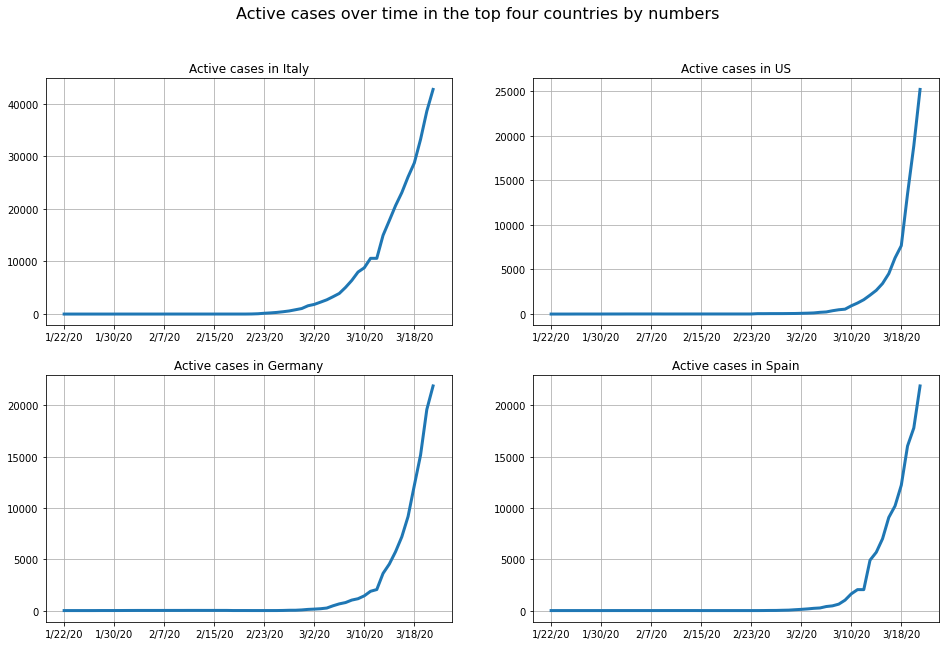

In [497]:
fig, ax = plt.subplots(2, 2, figsize=(16,10))

def plot_top4(da,num,xcol, ycol, title):
    ax[num].plot(da[xcol],da[ycol], lw=3)
    ax[num].set_title(title)
    ax[num].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[num].grid(True)
    
plot_top4(top_four_all, (0,0), "Date", top_four[0] + ' active', 'Active cases in {}'.format(top_four[0]))
plot_top4(top_four_all, (0,1), "Date", top_four[1] + ' active', 'Active cases in {}'.format(top_four[1]))
plot_top4(top_four_all, (1,0), "Date", top_four[2] + ' active', 'Active cases in {}'.format(top_four[2]))
plot_top4(top_four_all, (1,1), "Date", top_four[3] + ' active', 'Active cases in {}'.format(top_four[3]))
fig.suptitle('Active cases over time in the top four countries by numbers', fontsize=16)

plt.show()

As on 18.03, all of the top four countries with the most active cases are still in a steep slope of growth of cases with the exception of Iran, whose growth slope is getting gentler. 

We compare the curves above with the one from China, the country with the most reported cases so far but with a declining number of new positive cases. 
<br> We added also the graph from South Korea where the active cases are starting to drop since mif March.
<br> In both countries the peak of active cases shows in the graphs around a month since the curve starting to get up in the data of significant numbers of cases. Both countries took strict measures to content the spread of the virus including lockdowns of hotspots, social distancing, self-isolation and closing of public places and schools.

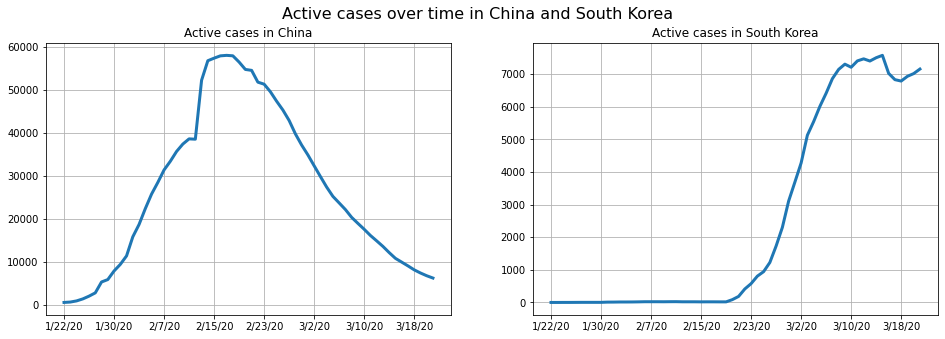

In [498]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
plot_top4(top_four_all, 0, "Date", 'China active', 'Active cases in China')
plot_top4(top_four_all, 1, "Date", 'South Korea active', 'Active cases in South Korea')
fig.suptitle('Active cases over time in China and South Korea', fontsize=16)

plt.show()

# Country Analysis - Italy

Import the latest reports from the Presidenza del Consiglio dei Ministri - Dipartimento della Protezione Civile. 
<br>Date of the latest data to be gathered is yesterday to ensure the data is available as the files are updated daily at midnight. 
<br>We use the date variable "ieri" to build the urls dynamically. The date format used in the Italian repository differs from the one used by the CSSE at Johns Hopkins University, this is why we need to build it.

In [499]:
ieri = date.today() - timedelta(days=1)
ieri = ieri.strftime("%Y%m%d")

In [500]:
nat_url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
reg_url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"
reg_daily_url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-{}.csv".format(ieri)
prov_url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv" 
da_national = get_raw_data(nat_url)
da_region = get_raw_data(reg_url)
da_daily_region = get_raw_data(reg_daily_url)
da_province = get_raw_data(prov_url)

We rename the columns to translate them to English.

In [501]:
da_national.columns

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare',
       'totale_attualmente_positivi', 'nuovi_attualmente_positivi',
       'dimessi_guariti', 'deceduti', 'totale_casi', 'tamponi'],
      dtype='object')

In [502]:
da_national = da_national.rename(columns={'data':"timestamp", 'stato':"state", 
                            'ricoverati_con_sintomi':"hospitalized with symptoms", 
                            'terapia_intensiva':"intensive care",
                            'totale_ospedalizzati':"total hospitalized",
                            'isolamento_domiciliare':"self-isolation",
                            'totale_attualmente_positivi':"total currently positive", 
                            'nuovi_attualmente_positivi':"new positive",
                            'dimessi_guariti':"recovered", 
                            'deceduti':"fatalities", 
                            'totale_casi':"total positive", 
                            'tamponi':"total tested"})
da_national.head(2)

,timestamp,state,hospitalized with symptoms,intensive care,total hospitalized,self-isolation,total currently positive,new positive,recovered,fatalities,total positive,total tested
0,2020-02-24 18:00:00,ITA,101,26,127,94,221,221,1,7,229,4324
1,2020-02-25 18:00:00,ITA,114,35,150,162,311,90,1,10,322,8623


In [503]:
da_region = da_region.rename(columns={'data':"date", 'stato':"state", 'codice_regione':"regional code", 
                          'denominazione_regione':"region", 'ricoverati_con_sintomi':"hospitalized with symptoms", 
                          'terapia_intensiva':"intensive care",'totale_ospedalizzati':"total hospitalized", 
                          'isolamento_domiciliare':"self-isolation", 
                          'totale_attualmente_positivi':"total currently positive", 
                          'nuovi_attualmente_positivi':"new positive",'dimessi_guariti':"recovered", 
                          'deceduti':"fatalities", 'totale_casi':"total positive", 'tamponi':"total tested"})
da_region.head(2)

,date,state,regional code,region,lat,long,hospitalized with symptoms,intensive care,total hospitalized,self-isolation,total currently positive,new positive,recovered,fatalities,total positive,total tested
0,2020-02-24 18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,5
1,2020-02-24 18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0


In [504]:
da_daily_region = da_daily_region.rename(columns={'data':"date", 'stato':"state", 'codice_regione':"regional code", 
                          'denominazione_regione':"region", 'ricoverati_con_sintomi':"hospitalized with symptoms", 
                          'terapia_intensiva':"intensive care",'totale_ospedalizzati':"total hospitalized", 
                          'isolamento_domiciliare':"self-isolation", 
                          'totale_attualmente_positivi':"total currently positive", 
                          'nuovi_attualmente_positivi':"new positive",'dimessi_guariti':"recovered", 
                          'deceduti':"fatalities", 'totale_casi':"total positive", 'tamponi':"total tested"})
da_daily_region.head(2)

,date,state,regional code,region,lat,long,hospitalized with symptoms,intensive care,total hospitalized,self-isolation,total currently positive,new positive,recovered,fatalities,total positive,total tested
0,2020-03-21 17:00:00,ITA,13,Abruzzo,42.351222,13.398438,185,44,229,265,494,72,13,22,529,3035
1,2020-03-21 17:00:00,ITA,17,Basilicata,40.639471,15.805148,12,7,19,47,66,14,0,0,66,522


## Time trends on national level 

<function matplotlib.pyplot.show(*args, **kw)>

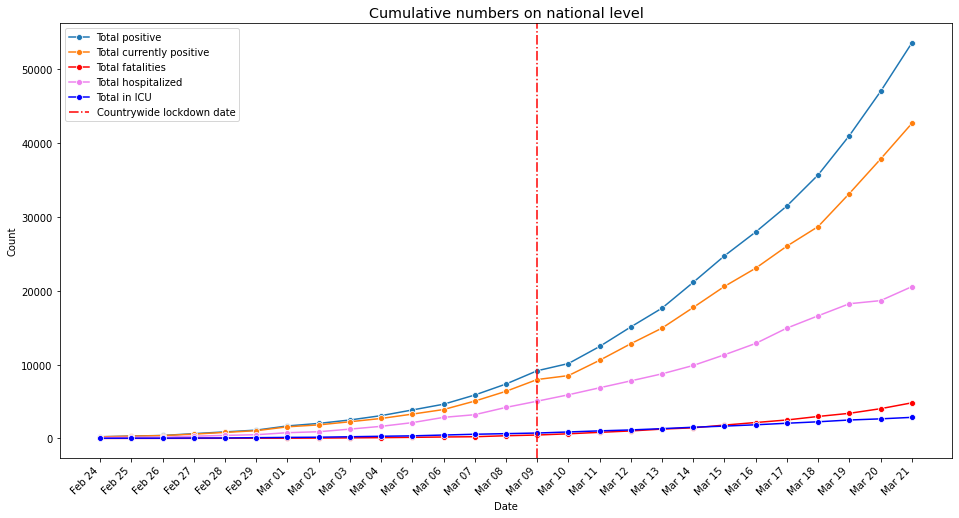

In [505]:
plt.figure(figsize=(16,8))
plt.title("Cumulative numbers on national level", size="x-large")
rng = da_national["timestamp"]
rng = [datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S').strftime("%b %d") for x in rng]
da_national["date"] = rng
sns.lineplot(x=da_national["date"], y=da_national["total positive"], 
             label = "Total positive", marker = "o")
sns.lineplot(x=da_national["date"], y=da_national["total currently positive"], 
             label = "Total currently positive", marker = "o")
sns.lineplot(x=da_national["date"], y=da_national["fatalities"], 
             label = "Total fatalities", marker = "o", color = "red")
sns.lineplot(x=da_national["date"], y=da_national["total hospitalized"], 
             label = "Total hospitalized", marker = "o", color="violet")
sns.lineplot(x=da_national["date"], y=da_national["intensive care"], 
             label = "Total in ICU", marker = "o", color="blue").set(xlabel = "Date", ylabel = "Count")
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'  
)
plt.axvline(x="Mar 09", ls="-.", c="red", label = "Countrywide lockdown date")
plt.legend(fontsize="medium")
plt.show

Active cases keep growing rapidly on national level. Following the trends from China and South Korea, we could infere that this behaviour is expected until at least one month since the countrywide lockdown.

## Country numbers in a nutshell

In [507]:
latest = da_national.loc[:,['total tested','total positive', 'total currently positive',
                            'recovered','self-isolation','total hospitalized',
                            'intensive care','fatalities']].tail(1)
latest["death rate [%]"] = 100*latest["fatalities"]/latest["total positive"]
latest.head()

,total tested,total positive,total currently positive,recovered,self-isolation,total hospitalized,intensive care,fatalities,death rate [%]
26,233222,53578,42681,6072,22116,20565,2857,4825,9.005562


In [523]:
ind = len(da_national) -1
perc = latest.drop(["total tested","death rate [%]"], axis=1)
perc = 100*perc/latest.loc[ind,"total tested"]

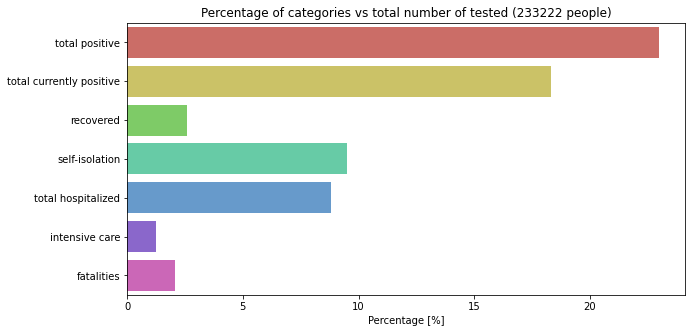

In [524]:
fig, ax = plt.subplots(figsize=(10,5))
plt.title("Percentage of categories vs total number of tested ({} people)".format(latest.loc[ind,"total tested"]), 
          size="large")
ax = sns.barplot(data=perc, 
     orient="h",
     palette = 'hls').set(xlabel = "Percentage [%]")

From all tested population we have the following figures in terms of percentage: 

In [525]:
perc

,total positive,total currently positive,recovered,self-isolation,total hospitalized,intensive care,fatalities
26,22.972961,18.300589,2.603528,9.48281,8.817779,1.225013,2.068844


## Analysis on regional level

In [526]:
da_daily_region["percentage of active [%]"] = round(100*da_daily_region[
                                    "total currently positive"]/latest.loc[ind,"total currently positive"],2)
da_daily_region["percentage of total positive [%]"] = round(
                                    100*da_daily_region["total positive"]/latest.loc[ind,"total positive"],2)

In [527]:
da_daily_region[["region","total tested","total positive","total currently positive",
                 "percentage of active [%]",
                 "percentage of total positive [%]"]].sort_values(
                 by="total currently positive", ascending=False).head(4)

,region,total tested,total positive,total currently positive,percentage of active [%],percentage of total positive [%]
9,Lombardia,66730,25515,17370,40.70,47.62
5,Emilia Romagna,24620,6705,5661,13.26,12.51
20,Veneto,53642,4617,4214,9.87,8.62
12,Piemonte,10701,3752,3506,8.21,7.00


In [528]:
fig = px.treemap(da_daily_region,
                 path=['region'],
                 values= da_daily_region['total positive'],
                 title='Regions with Active Cases in Italy: status {}'.format(ieri),
                 hover_data=['total positive', 'total currently positive', 'recovered','fatalities'],
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.show()

Lombardia is the region with the bigest share of cases of those currently active. 
<br>As the outbreak hit Lombardia first, the number of fatalities and recovered cases are higher, explaining the lower number of currently cases in comparison to the total of cases. 
<br>In the other regions, the outbreak started more recently, therefore the actual positive and total positive in those regions are very close to each other.

In [529]:
top_italy = da_daily_region.sort_values(by="total currently positive", ascending=False)["region"].head(4)

In [530]:
lomb_active_time = da_region[da_region["region"]=="Lombardia"][["date","total currently positive","fatalities","recovered"]]

<function matplotlib.pyplot.show(*args, **kw)>

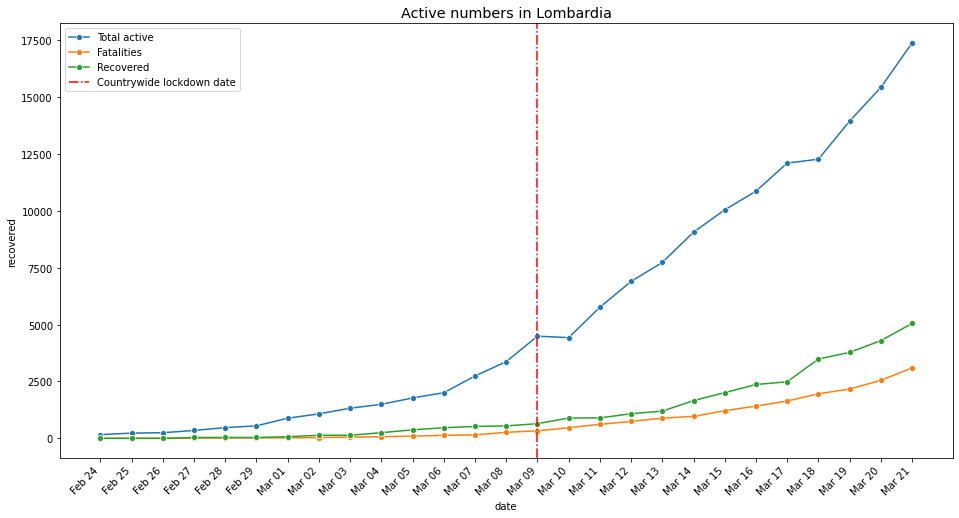

In [531]:
plt.figure(figsize=(16,8))
plt.title("Active numbers in Lombardia", size="x-large")
rng = lomb_active_time["date"]
rng = [datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S').strftime("%b %d") for x in rng]
lomb_active_time["date"] = rng
sns.lineplot(x=lomb_active_time["date"], y=lomb_active_time["total currently positive"], 
             label = "Total active", marker = "o")
sns.lineplot(x=lomb_active_time["date"], y=lomb_active_time["fatalities"], 
             label = "Fatalities", marker = "o")
sns.lineplot(x=lomb_active_time["date"], y=lomb_active_time["recovered"], 
             label = "Recovered", marker = "o")
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'  
)
plt.axvline(x="Mar 09", ls="-.", c="red", label = "Countrywide lockdown date")
plt.legend(fontsize="medium")
plt.show